# IMPORTAR LIBRER√çAS

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACI√ìN DE DATOS

In [87]:

# --- Energ√≠as gamma conocidas (keV) ---
energias_referencia = {
    "Cs-137": [32, 59.537, 121.06, 661.657],
    "Co-60": [1173.238, 1332.50],
    "Zn-65": [1115.546, 770.4, 344.9]
}

# --- Picos manuales en canales ---
picos_canales = {
    "Co-60": [644, 727],
    "Cs-137": [18, 43, 117, 381],
    "Zn-65": [618, 459, 288]
}

# --- Archivos CSV ---
archivos = {
    "Co-60": "C:/Users/PcVip/Downloads/PRACTICA 1 ESPECTROS/espectro_Co60.csv",
    "Cs-137": "C:/Users/PcVip/Downloads/PRACTICA 1 ESPECTROS/espectro_cs137.csv",
    "Zn-65": "C:/Users/PcVip/Downloads/PRACTICA 1 ESPECTROS/espectro_Zn65.csv"
}

# --- Colores para gr√°ficos ---
colores = {
    "Co-60": "orange",
    "Cs-137": "deepskyblue", 
    "Zn-65": "limegreen"
}

#  FUNCIONES AUXILIARES

In [88]:
def leer_espectro(ruta):
    """Lee un CSV y devuelve canales y cuentas como arrays numpy."""
    df = pd.read_csv(ruta)
    df.columns = [c.strip().lower() for c in df.columns]
    col_canal = next(c for c in df.columns if "canal" in c or "energy" in c)
    col_cuentas = next(c for c in df.columns if "cuent" in c or "count" in c)
    return df[col_canal].to_numpy(), df[col_cuentas].to_numpy()

def lineal(x, a, b):
    """Funci√≥n lineal para calibraci√≥n."""
    return a * x + b

def calibracion_lineal(canales_detectados, energias_ref):
    """Calcula los par√°metros de calibraci√≥n lineal (a, b)."""
    params, _ = curve_fit(lineal, canales_detectados, energias_ref)
    return params

def aplicar_calibracion(canales, a, b):
    """Convierte canales a energ√≠a usando calibraci√≥n lineal."""
    return lineal(canales, a, b)

def calcular_intensidades(canales_detectados, cuentas):
    """Calcula intensidades relativas de los picos."""
    intensidades = [cuentas[int(c)] if int(c) < len(cuentas) else 0 for c in canales_detectados]
    max_intensidad = max(intensidades) if intensidades else 1
    intensidades_rel = [(i / max_intensidad) * 100 for i in intensidades]
    return intensidades, intensidades_rel

# AN√ÅLISIS PRINCIPAL Y CALIBRACI√ìN

In [89]:
# --- Almacenamiento de datos ---
espectros_crudos = {}
espectros_calibrados = {}
parametros_calibracion = {}

# --- Procesar cada is√≥topo ---
for iso, ruta in archivos.items():
    
    # Leer datos
    canales, cuentas = leer_espectro(ruta)
    espectros_crudos[iso] = (canales, cuentas)
    
    # Obtener picos y energ√≠as de referencia
    canales_detectados = np.array(picos_canales[iso])
    energias_ref = np.array(energias_referencia[iso])
    
    # Calibraci√≥n lineal
    a, b = calibracion_lineal(canales_detectados, energias_ref)
    parametros_calibracion[iso] = (canales_detectados, energias_ref, a, b)
    
    # Aplicar calibraci√≥n
    energia = aplicar_calibracion(canales, a, b)
    espectros_calibrados[iso] = pd.DataFrame({
        "Energia_keV": energia,
        "Cuentas": cuentas
    })

# GR√ÅFICO 1: REGRESIONES LINEALES DE CALIBRACI√ìN

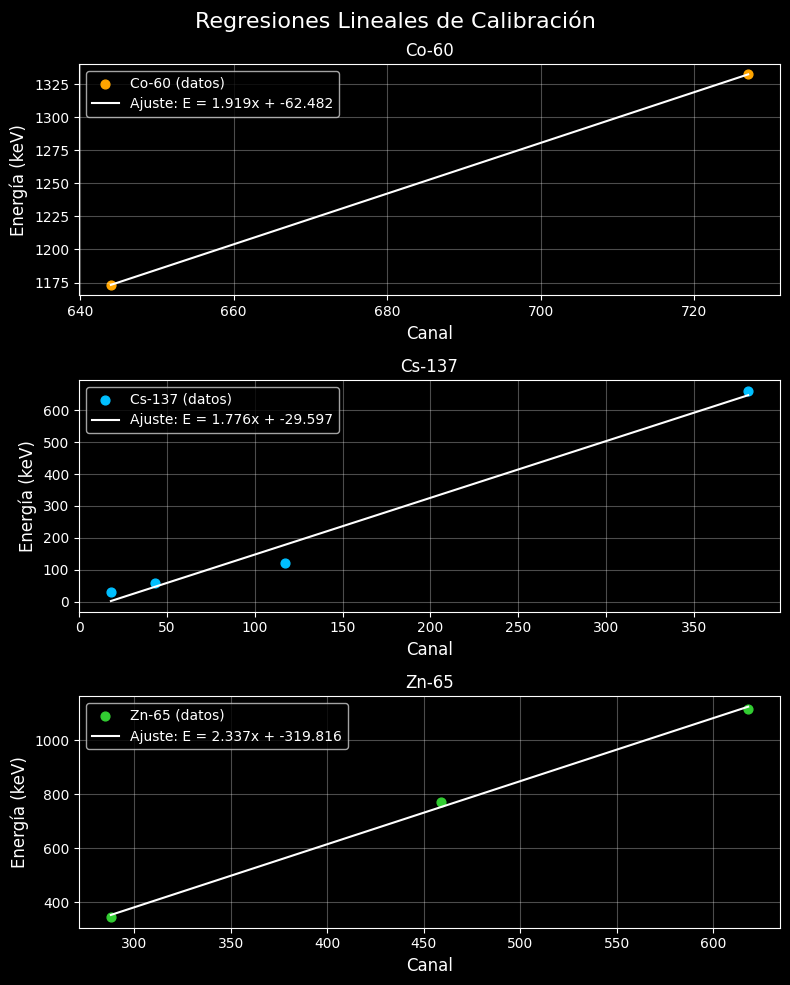

In [90]:
plt.style.use('dark_background')
fig, axs = plt.subplots(len(parametros_calibracion), 1, figsize=(8, 10))
fig.suptitle("Regresiones Lineales de Calibraci√≥n", fontsize=16)

for i, (iso, (x, y, a, b)) in enumerate(parametros_calibracion.items()):
    axs[i].scatter(x, y, s=40, label=f"{iso} (datos)", color=colores.get(iso))
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = lineal(x_fit, a, b)
    axs[i].plot(x_fit, y_fit, color='white', lw=1.5,
                label=f"Ajuste: E = {a:.3f}x + {b:.3f}")
    axs[i].set_xlabel("Canal", fontsize=12)
    axs[i].set_ylabel("Energ√≠a (keV)", fontsize=12)
    axs[i].legend()
    axs[i].grid(alpha=0.3)
    axs[i].set_title(f"{iso}")

plt.tight_layout()
plt.show()

# GR√ÅFICO 2: AN√ÅLISIS INDIVIDUAL POR IS√ìTOPO

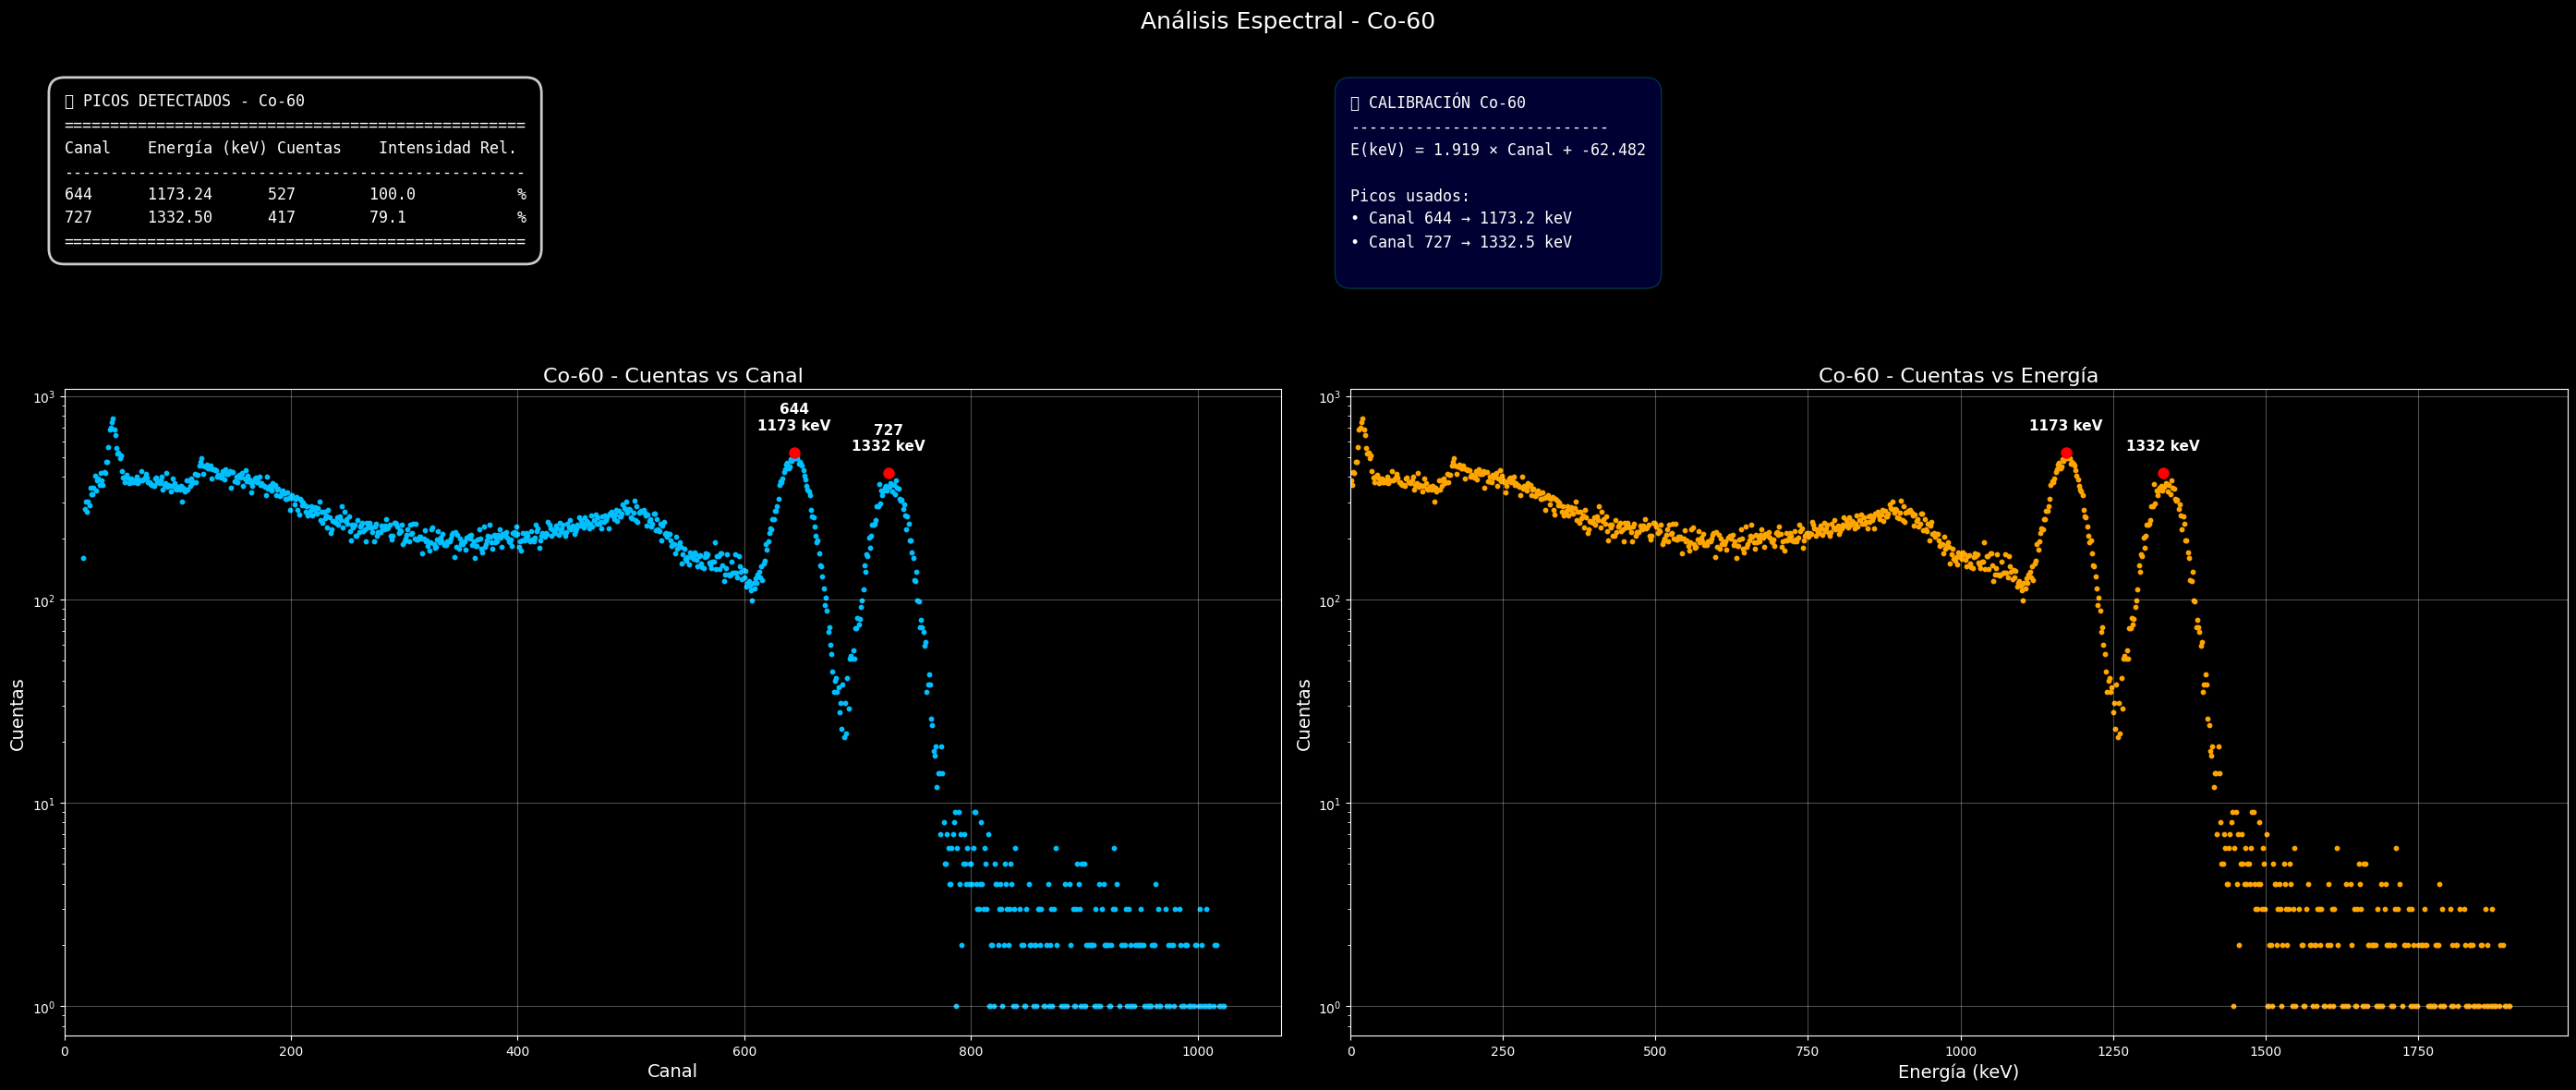

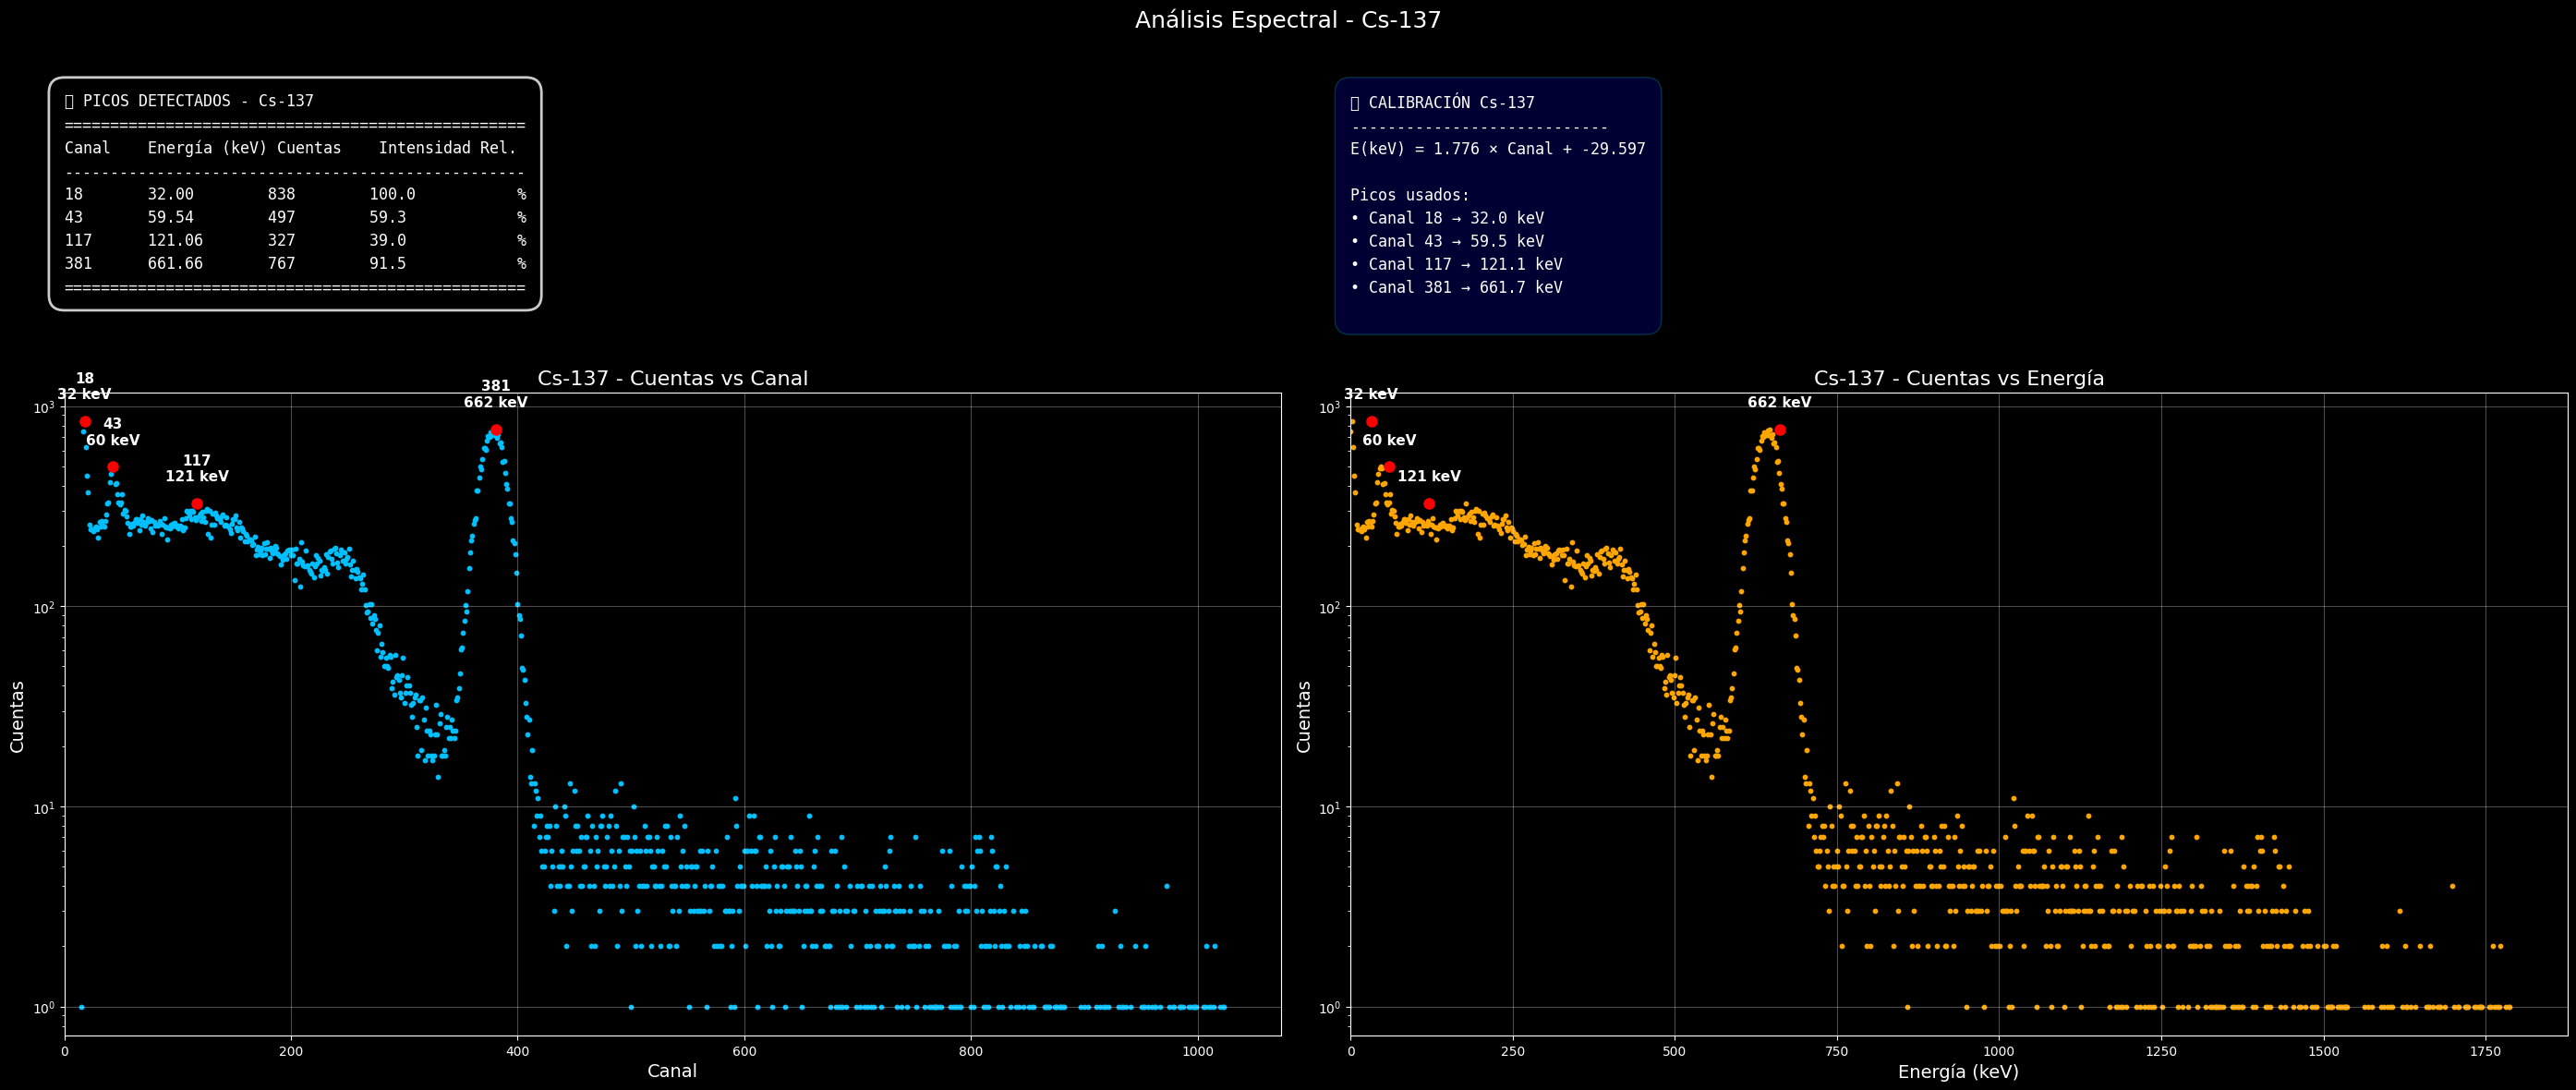

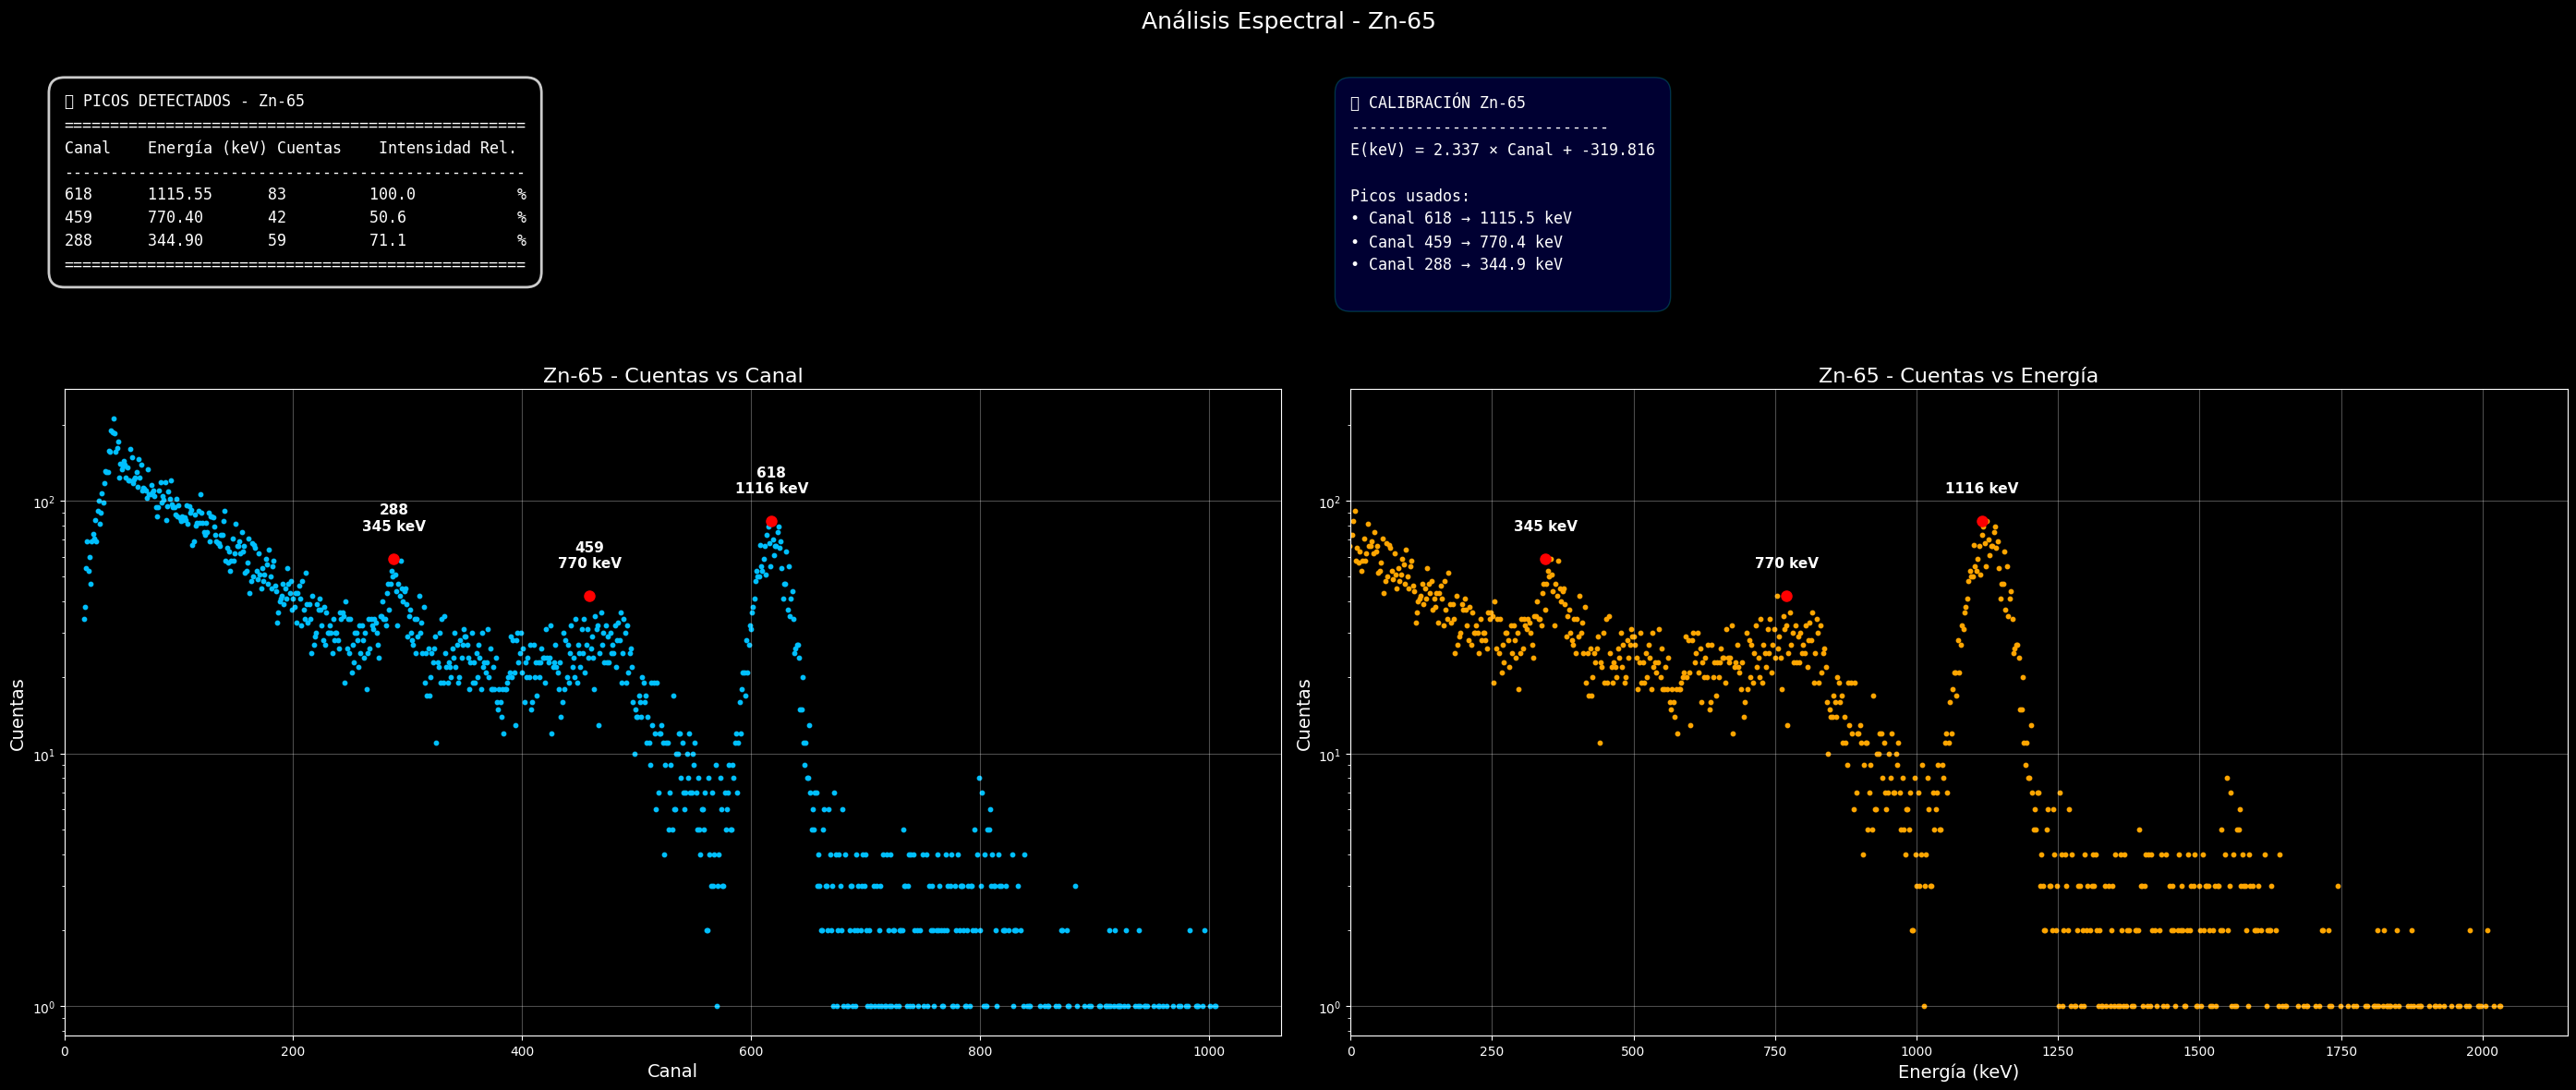

In [91]:
for iso in archivos.keys():
    
    # Obtener datos
    canales, cuentas = espectros_crudos[iso]
    canales_detectados, energias_ref, a, b = parametros_calibracion[iso]
    energia = aplicar_calibracion(canales, a, b)
    
    # Calcular intensidades
    intensidades, intensidades_rel = calcular_intensidades(canales_detectados, cuentas)
    
    # --- CONFIGURAR GRID 2x2 ---
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(28, 12))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 2.5])
    
    # TABLA ARRIBA IZQUIERDA
    ax_tabla = fig.add_subplot(gs[0, 0])
    ax_tabla.axis('off')
    tabla_texto = f"üìä PICOS DETECTADOS - {iso}\n"
    tabla_texto += "="*50 + "\n"
    tabla_texto += f"{'Canal':<8} {'Energ√≠a (keV)':<12} {'Cuentas':<10} {'Intensidad Rel.'}\n"
    tabla_texto += "-"*50 + "\n"
    for c, e, cuenta, int_rel in zip(canales_detectados, energias_ref, intensidades, intensidades_rel):
        tabla_texto += f"{c:<8} {e:<12.2f} {cuenta:<10} {int_rel:<15.1f} %\n"
    tabla_texto += "="*50
    ax_tabla.text(0.0, 1.0, tabla_texto, fontfamily='monospace', fontsize=12,
                  verticalalignment='top', linespacing=1.5,
                  bbox=dict(boxstyle="round,pad=1.0", facecolor='black', alpha=0.8,
                            edgecolor='white', linewidth=2))
    
    # CALIBRACI√ìN ARRIBA DERECHA
    ax_calib = fig.add_subplot(gs[0, 1])
    ax_calib.axis('off')
    calib_texto = f"üîß CALIBRACI√ìN {iso}\n"
    calib_texto += "-"*28 + "\n"
    calib_texto += f"E(keV) = {a:.3f} √ó Canal + {b:.3f}\n\n"
    calib_texto += "Picos usados:\n"
    for c, e in zip(canales_detectados, energias_ref):
        calib_texto += f"‚Ä¢ Canal {c} ‚Üí {e:.1f} keV\n"
    ax_calib.text(0.0, 1.0, calib_texto, fontfamily='monospace', fontsize=12,
                  verticalalignment='top', linespacing=1.5,
                  bbox=dict(boxstyle="round,pad=1.0", facecolor='blue', alpha=0.2,
                            edgecolor='cyan', linewidth=1))
    
    # GRAFICO ABAJO IZQUIERDA: Cuentas vs Canal
    ax1 = fig.add_subplot(gs[1, 0])
    ax1.scatter(canales, cuentas, s=10, color='deepskyblue')
    for c, e in zip(canales_detectados, energias_ref):
        y = cuentas[int(c)] if int(c) < len(cuentas) else max(cuentas)
        ax1.plot(c, y, 'ro', markersize=8)
        ax1.text(c, y * 1.3, f"{int(c)}\n{e:.0f} keV", color='white', 
                fontsize=11, ha='center', fontweight='bold')
    ax1.set_xlabel("Canal", fontsize=14)
    ax1.set_ylabel("Cuentas", fontsize=14)
    ax1.set_title(f"{iso} - Cuentas vs Canal", fontsize=16)
    ax1.set_yscale('log')
    ax1.grid(alpha=0.3)
    ax1.set_xlim(0, max(canales) * 1.05)
    
    # GRAFICO ABAJO DERECHA: Cuentas vs Energ√≠a
    ax2 = fig.add_subplot(gs[1, 1])
    ax2.scatter(energia, cuentas, s=10, color='orange')
    for c, e in zip(canales_detectados, energias_ref):
        y = cuentas[int(c)] if int(c) < len(cuentas) else max(cuentas)
        ax2.plot(e, y, 'ro', markersize=8)
        ax2.text(e, y * 1.3, f"{e:.0f} keV", color='white', 
                fontsize=11, ha='center', fontweight='bold')
    ax2.set_xlabel("Energ√≠a (keV)", fontsize=14)
    ax2.set_ylabel("Cuentas", fontsize=14)
    ax2.set_title(f"{iso} - Cuentas vs Energ√≠a", fontsize=16)
    ax2.set_yscale('log')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, max(energia) * 1.05)
    
    plt.suptitle(f"An√°lisis Espectral - {iso}", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# GR√ÅFICO 3: ESPECTROS COMBINADOS

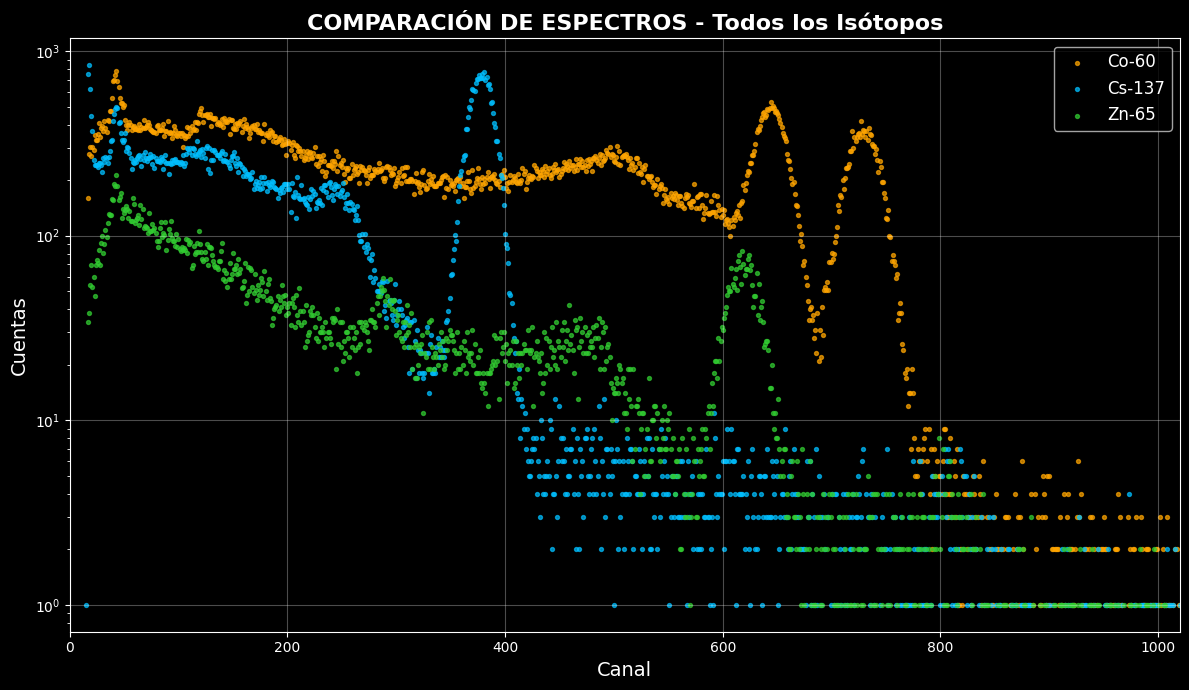

In [92]:
def graficar_combinado(espectros):
    """Genera un gr√°fico combinado de todos los espectros."""
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 7))
    for iso, (canales, cuentas) in espectros.items():
        plt.scatter(canales, cuentas, s=8, label=iso, color=colores.get(iso), alpha=0.7)
    plt.xlabel("Canal", fontsize=14)
    plt.ylabel("Cuentas", fontsize=14)
    plt.title("COMPARACI√ìN DE ESPECTROS - Todos los Is√≥topos", fontsize=16, fontweight='bold')
    plt.yscale('log')
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.xlim(0, 1020)
    plt.tight_layout()
    plt.show()

graficar_combinado(espectros_crudos)

#  GR√ÅFICO 4: MAPA DE CALOR COMPARATIVO

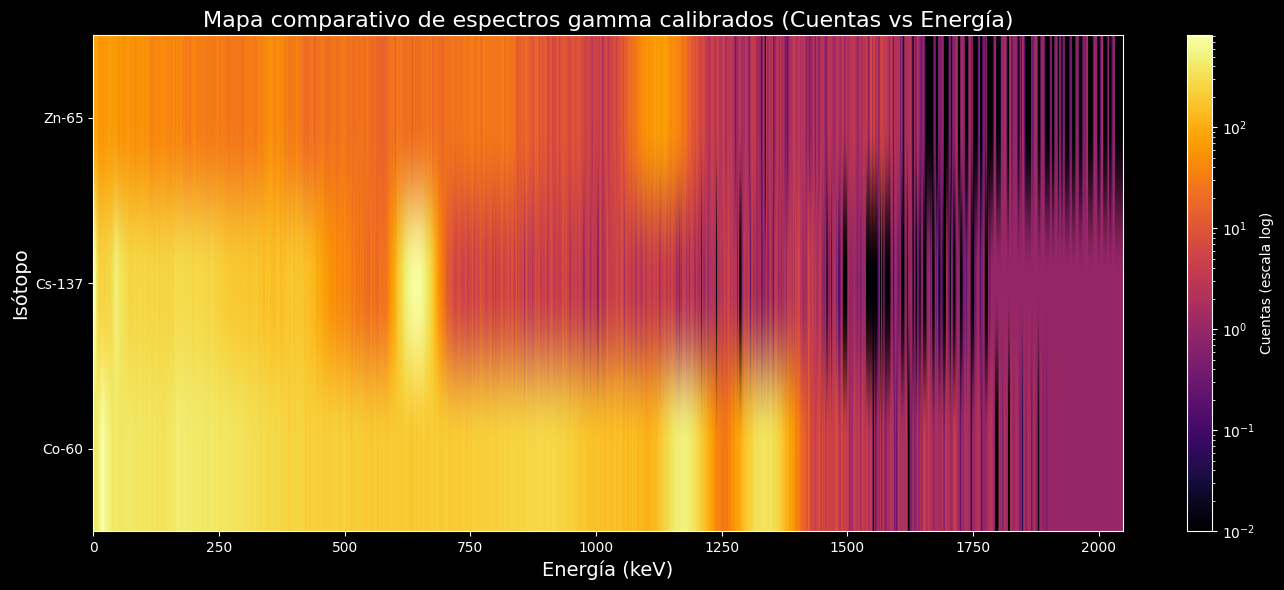

In [93]:
# Crear matriz a partir de los espectros calibrados
isos = list(espectros_calibrados.keys())

# Encontrar el eje de energ√≠a com√∫n
min_energia = min(df["Energia_keV"].min() for df in espectros_calibrados.values())
max_energia = max(df["Energia_keV"].max() for df in espectros_calibrados.values())
num_puntos = max(len(df["Energia_keV"]) for df in espectros_calibrados.values())
eje_energia = np.linspace(min_energia, max_energia, num_puntos)

# Interpolar todos los espectros al mismo eje de energ√≠a
matriz = []
for iso in isos:
    df = espectros_calibrados[iso]
    energia = df["Energia_keV"].to_numpy()
    cuentas = df["Cuentas"].to_numpy()
    cuentas_interp = np.interp(eje_energia, energia, cuentas)
    matriz.append(cuentas_interp)

matriz = np.array(matriz)
matriz[matriz <= 0] = 1e-2  # evitar log(0)

# Graficar el mapa de calor
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 6))

im = ax.imshow(
    matriz,
    aspect='auto',
    origin='lower',
    cmap='inferno',
    norm=colors.LogNorm(vmin=1e-2, vmax=np.max(matriz)),
    extent=[min_energia, max_energia, 0, len(isos)]
)

# Etiquetas y formato
ax.set_xlabel("Energ√≠a (keV)", fontsize=14)
ax.set_ylabel("Is√≥topo", fontsize=14)
ax.set_yticks(np.arange(len(isos)) + 0.5)
ax.set_yticklabels(isos)
ax.set_xlim(0, None)

cbar = plt.colorbar(im, ax=ax, label="Cuentas (escala log)")
ax.set_title("Mapa comparativo de espectros gamma calibrados (Cuentas vs Energ√≠a)", fontsize=16)

plt.tight_layout()
plt.show()